In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table, join, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import Euclid

%erun Phosphoros 0.18

from PhzCLI.PlotSpecZComparison import compute_stats, SpeczPhotozPlot, displayHistogram

plt.rcParams['figure.figsize'] = (20, 10)

NNPZ run using the SC8 reference sample over *only* galaxies from tile 78831. SNR ratio of 10 applied to the input.

In [2]:
mer = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/mer_gal.fits')

Run with 300 neighbors, we mask flagged objects

In [3]:
phz300 = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/run300.fits', hdu=1)
pdz_bins = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/run300.fits', hdu=2)
mask = (phz300['NEIGHBOR_WEIGHTS'].sum(axis=1) > 0) & (phz300['FLAGS_1'] == 0) & (~np.isnan(phz300['REDSHIFT_MEDIAN']))
t = join(mer, phz300[mask], 'OBJECT_ID')

Sort weights from higher (closest) to lower (furthest)

In [4]:
weights_sorted = np.flip(np.sort(t['NEIGHBOR_WEIGHTS'], axis=1), axis=1)
assert (weights_sorted[:,0] > weights_sorted[:,-1]).all()

In [5]:
neighbors = np.arange(weights_sorted.shape[1]) + 1

In [6]:
def plot_dist(weights, ax):
    normed = weights / weights[:,0].reshape(-1,1)
    quanta = np.quantile(normed, [0.5, 0.25, 0.75, 0.05, 0.95], axis=0)
    
    ax.plot(neighbors, quanta[0], 'r-', label='Median')
    ax.fill_between(neighbors, quanta[3], quanta[4], label='5% - 95%', color='#ccedff')
    ax.fill_between(neighbors, quanta[1], quanta[2], label='25% - 75%', color='#ffe3cc')
    ax.set_xlabel('Neighbor')
    ax.set_ylabel('Weight / Max.Weight')

    ax.axvline(neighbors[quanta[0] < 0.5][0], linestyle='--', color='gray', label='Closest / 2')
    ax.axvline(neighbors[quanta[0] < 0.1][0], linestyle='--', color='green', label='Closest / 10')
    if (quanta[0] < 0.01).any():
        ax.axvline(neighbors[quanta[0] < 0.01][0], linestyle='--', color='orange', label='Closest / 100')

    ax.set_title('Normalized to max. weight')
    ax.legend()

# Distribution of the ratio weight neighbor / weight closest

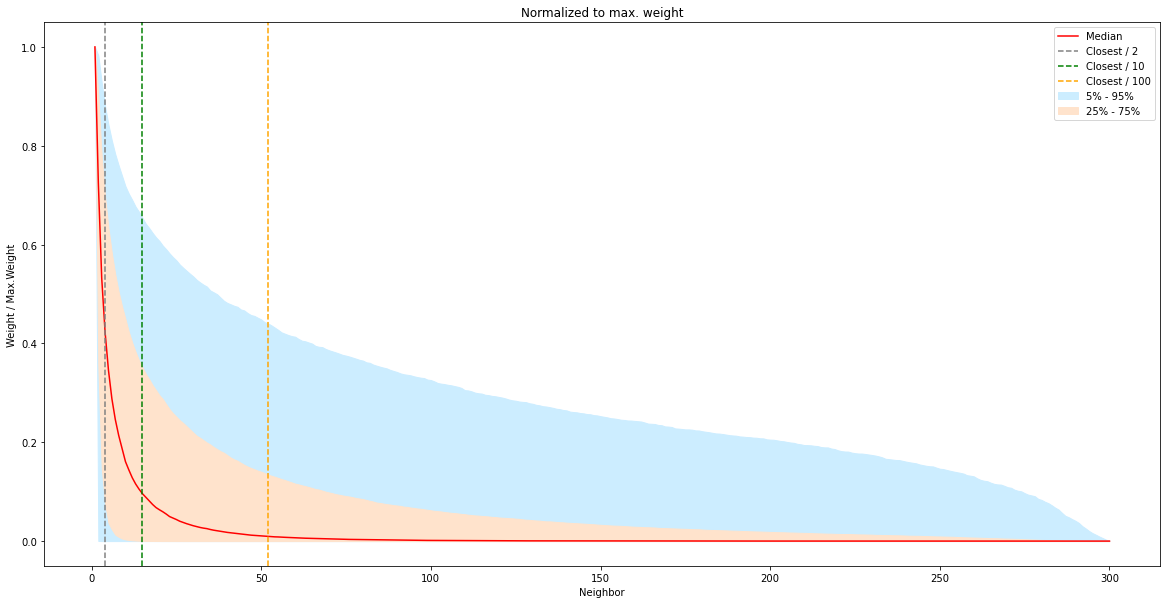

In [7]:
fig = plt.figure()
plot_dist(weights_sorted, plt.gca())

## Distribution binned by VIS magnitude

In [8]:
mags = t['FLUX_DETECTION_TOTAL'].to(u.ABmag)
mag_bins = np.linspace(22, 26, 8)
mag_bins = (mag_bins[:-1] + mag_bins[1:])/2
len(mag_bins)

7

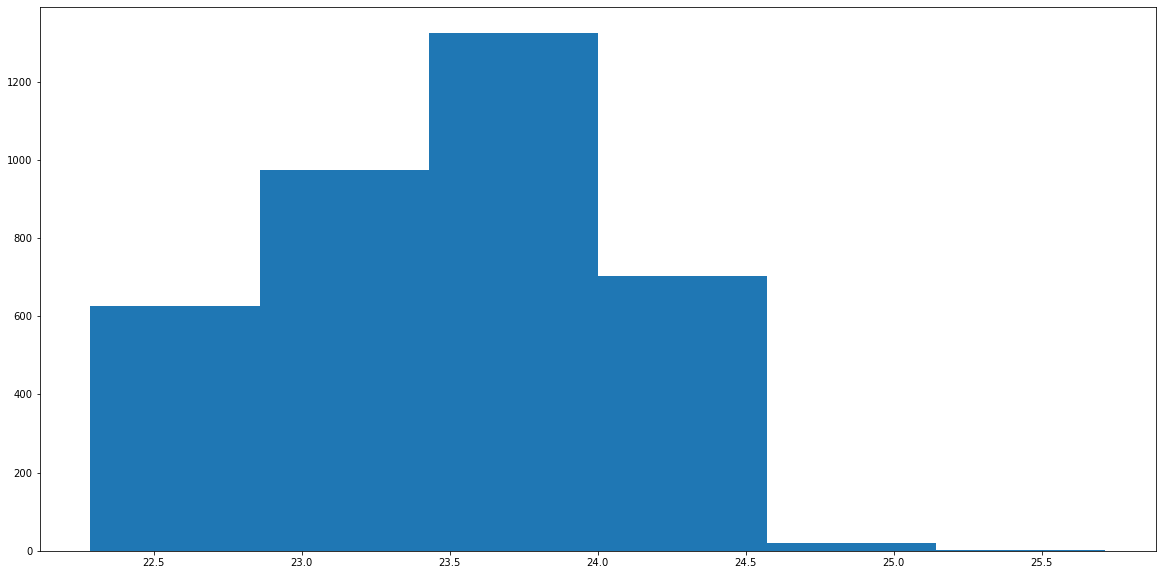

In [9]:
plt.hist(mags.value, bins=mag_bins)
plt.show()

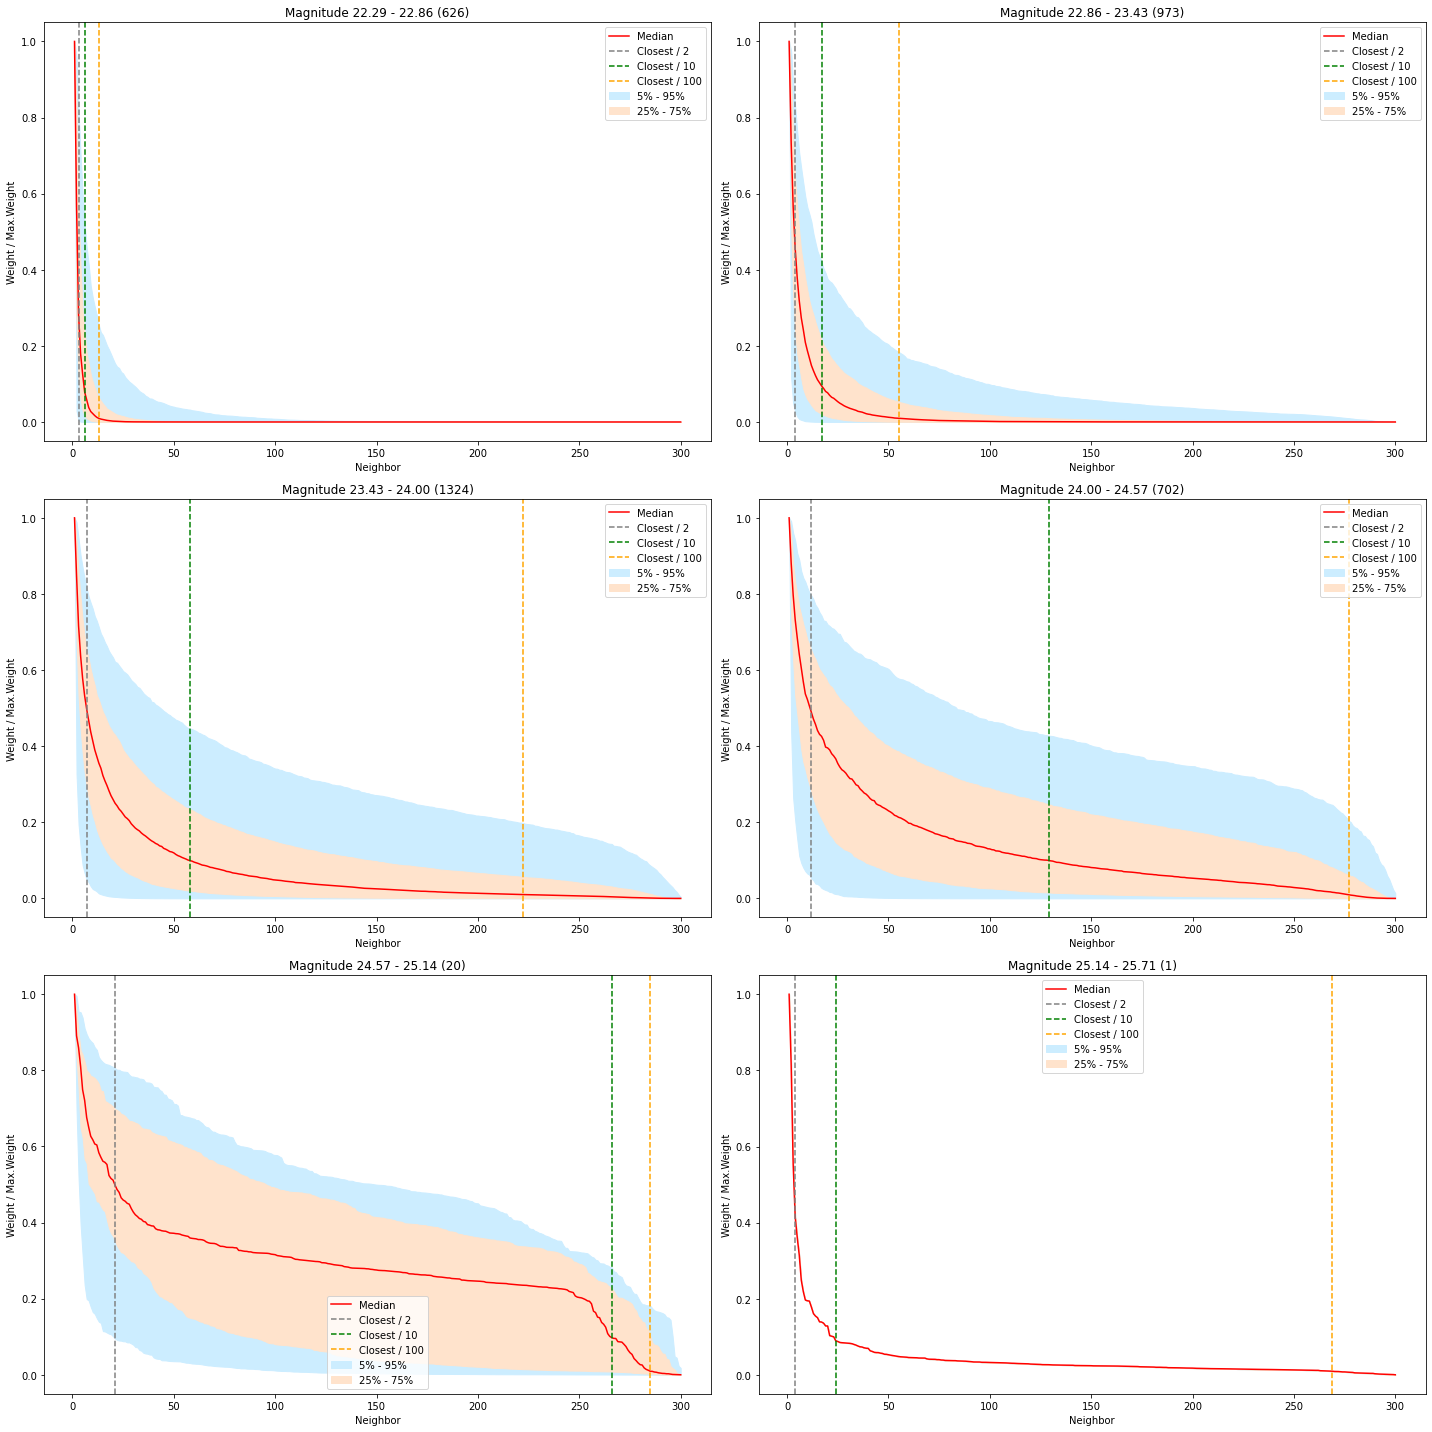

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))

for i, ax in enumerate(axes.ravel()):
    mask = (mags.value >= mag_bins[i]) & (mags.value < mag_bins[i+1])
    plot_dist(weights_sorted[mask], ax)
    ax.set_title(f'Magnitude {mag_bins[i]:.2f} - {mag_bins[i+1]:.2f} ({mask.sum()})')

plt.tight_layout()
plt.show()

# Load a run with the default configuration (30 neighbors)

In [11]:
phz30 = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/run30.fits', hdu=1)
mask = (phz30['NEIGHBOR_WEIGHTS'].sum(axis=1) > 0) & (phz30['FLAGS_1'] == 0)
tall = join(t, phz30[mask], 'OBJECT_ID', table_names=['300', '30'])

# Compare results

## Statistics for 300 neighbors

In [12]:
stats300 = compute_stats(tall['REDSHIFT_MEDIAN_300'], tall['Z_OBS'])

--> Mean                :  0.02856425415404386
--> Median              :  0.008430206216871738
--> Sigma               :  0.14929224549880796
--> Mad                 :  0.03739504516124725
--> Outliers            :  10.303548525010688 %
--> Sigma (no outliers) :  0.03489592


/opt/miniconda3/envs/phz/lib/python3.7/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Statistics for 30 neighbors

In [13]:
stats30 = compute_stats(tall['REDSHIFT_MEDIAN_30'], tall['Z_OBS'])

--> Mean                :  0.02971153047259112
--> Median              :  0.008904419839382172
--> Sigma               :  0.15174087197278088
--> Mad                 :  0.036765940487384796
--> Outliers            :  10.410431808465155 %
--> Sigma (no outliers) :  0.03486789


# Comparison median redshift using 30 vs using 300

In [14]:
stats_vs = compute_stats(tall['REDSHIFT_MEDIAN_300'], tall['REDSHIFT_MEDIAN_30'])

--> Mean                :  -0.00042028996
--> Median              :  0.0
--> Sigma               :  0.033724785
--> Mad                 :  0.0012601514
--> Outliers            :  0.7054296707994869 %
--> Sigma (no outliers) :  0.014536325


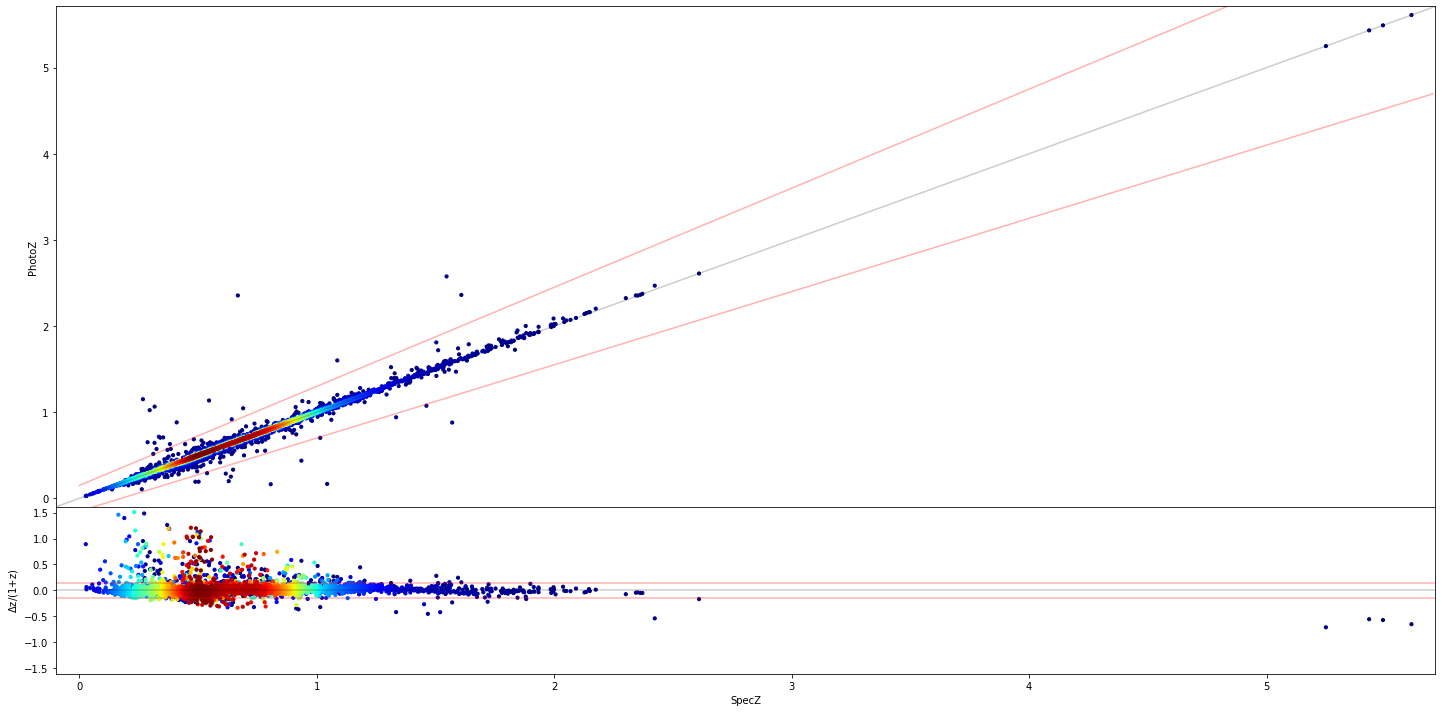

In [15]:
SpeczPhotozPlot(tall['OBJECT_ID'], specz=tall['REDSHIFT_MEDIAN_300'], photz=tall['REDSHIFT_MEDIAN_30'], data=stats300[0])

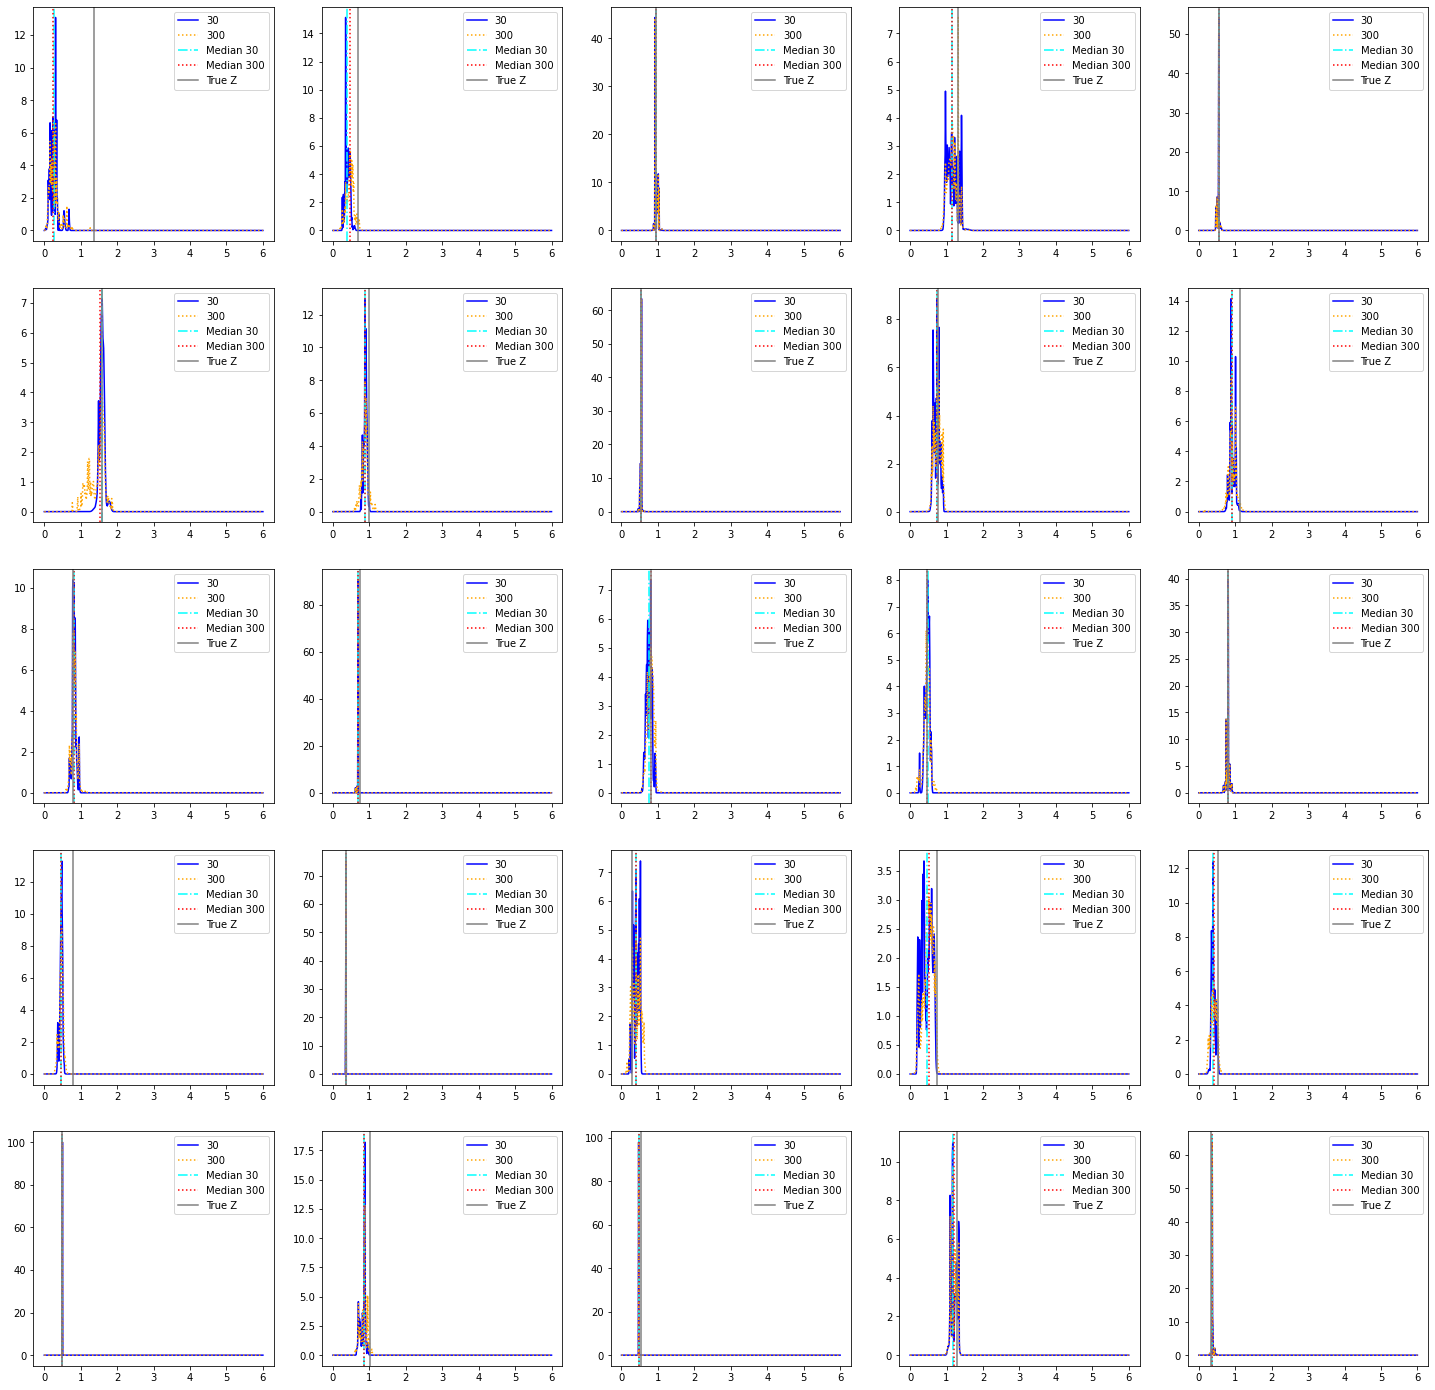

In [18]:
idx = np.random.choice(len(tall), 25)

fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for i, ax in zip(idx, axes.ravel()):
    ax.plot(pdz_bins, tall['REDSHIFT_PDF_30'][i], '-', color='blue', label='30')
    ax.plot(pdz_bins, tall['REDSHIFT_PDF_300'][i], ':', color='orange', label='300')
    ax.axvline(tall['REDSHIFT_MEDIAN_30'][i], linestyle='-.' ,color='cyan', label='Median 30')
    ax.axvline(tall['REDSHIFT_MEDIAN_300'][i], linestyle=':', color='red', label='Median 300')
    ax.axvline(tall['Z_OBS'][i], linestyle='-', color='gray', label='True Z')
    ax.legend()